<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/heatmap_to_bbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = ['1Goto2KHZrlh-ZJhBbEoSwZddXHUI4jIV']
downloaded = drive.CreateFile({'id':id[0]}) 
downloaded.GetContentFile('features.zip')
!unzip features.zip


Archive:  features.zip
replace features/input.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: features/input.jpeg     
  inflating: __MACOSX/features/._input.jpeg  
  inflating: features/feature_map_1024.npy  
  inflating: __MACOSX/features/._feature_map_1024.npy  
  inflating: features/gradcam_resize.npy  
  inflating: __MACOSX/features/._gradcam_resize.npy  
  inflating: features/gradcam_allcls.npy  
  inflating: __MACOSX/features/._gradcam_allcls.npy  


multilabel gt [1 0 0 1]<br>
multilabel prediction [0.7 0.4 0.3 0.9]<br>
cls0: Gradient -> Avg -> thr=0.1 (>0.08) -> exits <br>
cls1: Gradient -> Avg -> thr=0.0.03 (>0.08) -> not exits <br>
cls2: Gradient -> Avg -> thr=0.0.01 (>0.08) -> not exits <br>
cls3: Gradient -> Avg -> thr=0.0.2 (>0.08) ->  exits <br>
Cls3 let's consider repeated/duplicate two instruments, 
after thr, you are detection obj using cv.rect.. method. If there are two objects then you consider repeated instruments for this cls.

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

heat_map = np.load('features/gradcam_allcls.npy') # 
feature_map = np.load('features/feature_map_1024.npy')
heat_map = torch.from_numpy(heat_map) # [1, 16, 20]->[5, 16, 20]
feature_map = torch.from_numpy(feature_map) # [1, 1024, 16, 20] # torch squeeze()
heat_map = heat_map.repeat(1024,1,1,1)# [5, 16, 20] -> [1024, 5, 16, 20] #heat_map[:,0] -> [1024, 16, 20]
thr = 0.1 # need to tune
print(heat_map.shape, heat_map[:,0].shape, feature_map.shape)
for cls in range(5):
    feature_map_cls = feature_map[heat_map[None,:,cls]>thr] # v1 feature map as obj feature
    feature_cls = F.adaptive_avg_pool1d(feature_map_cls[None],512)
    #save
#feature_map_cls = heat_map[heat_map>thr] # v2 heatmap as obj feature

#print('Gradcam threshold feature:',feature_map_cls.shape)

print('Final feature for a cls:', feature_cls.shape)

torch.Size([1024, 5, 16, 20]) torch.Size([1024, 16, 20]) torch.Size([1, 1024, 16, 20])
Final feature for a cls: torch.Size([1, 512])


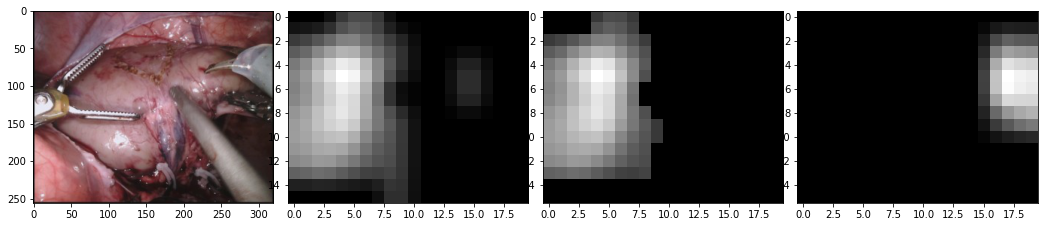

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
heat_map_orig = np.load('features/gradcam_allcls.npy')
thr = 0.2
heat_map = heat_map_orig.copy()
heat_map[heat_map<thr] = 0
img = Image.open('features/input.jpeg')
fig, ax = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw=dict(wspace=0.06, hspace=0.0))
ax[0].imshow(img)
ax[1].imshow(heat_map_orig[0], cmap='gray')
ax[2].imshow(heat_map[0], cmap='gray')
ax[3].imshow(heat_map_orig[1], cmap='gray')
#ax[2].imshow(feature_map[0,0], cmap='gray')